In [3]:
 # ----------- Overhead -------------

import pandas as pd
import numpy as np
# import scipy.stat as sps
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas import ExcelWriter
from sklearn import preprocessing
from sklearn.decomposition import PCA


In [4]:
df = pd.read_csv('data/NY property csv.csv')

In [5]:
# --------------- Fill in NAs and 0s ----------

# Create new variable BORO
df['BORO'] = ''
df['BORO'] = df.BBLE.str[0]

# ZIP, sort by BBLE and forward fill
df = df.sort_values(by = ['BBLE'])
df['ZIP'].fillna(method='ffill',inplace = True)

# Create ZIP3
df['ZIP3']= df["ZIP"].apply(lambda x: int(str(x)[0:3]))


df['ll_rate'] = df['LTFRONT']/df['LTDEPTH']
mean_llrate = np.mean(df['ll_rate'].dropna())
df['LTFRONT'] = df['LTFRONT'].fillna(value = (df['LTDEPTH'] * mean_llrate))
df['LTFRONT'] = df['LTDEPTH'].fillna(value = (df['LTFRONT'] / mean_llrate))
np.std(df['LTFRONT'])
# std = 73.7 without group
# two methods to set 0 values as missing values
df.loc[df['LTFRONT'] == 0, 'LTFRONT'] = np.nan
# df['LTFRONT'] = df['LTFRONT'].replace(0,np.nan)

# fill NA with average values grouped by BORO (if using TAXCLASS as well, 
# the filled values will be too big and there will be 2 missing values)
df['LTFRONT'] = df.groupby(['BORO','TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
df['LTFRONT'] = df.groupby(['TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))


df.loc[df['LTDEPTH'] == 0, 'LTDEPTH'] = np.nan
df['LTDEPTH'] = df.groupby(['BORO','TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
df['LTDEPTH'] = df.groupby(['TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))

# np.isnan(df['LTDEPTH']).sum()

# Calculate BLDFRONT/BLDDEPTH ratio
df.loc[df['BLDFRONT'] == 0, 'BLDFRONT'] = np.nan
df.loc[df['BLDDEPTH'] == 0, 'BLDDEPTH'] = np.nan

df['bb_rate'] = df['BLDFRONT']/df['BLDDEPTH']
# distribution of the ratio
# sns.distplot(df['BLDFRONT']/df['BLDDEPTH'].dropna(), bins = 1000,kde=False)
# plt.xlim(0,2)

median_bbrate = np.median(df['bb_rate'].dropna())
df['BLDFRONT'] = df['BLDFRONT'].fillna(value = (df['BLDDEPTH'] * median_bbrate))
df['BLDDEPTH'] = df['BLDDEPTH'].fillna(value = (df['BLDFRONT'] / median_bbrate))


# For BLDFRONT and BLDDEPTH, if group by both BORO and TAXCLASS, there will appear NaN as well.
df['BLDFRONT'] = df.groupby(['BORO','TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
df['BLDFRONT'] = df.groupby(['TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))

# np.isnan(df['BLDFRONT']).sum()
df['BLDDEPTH'] = df.groupby(['BORO','TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
df['BLDDEPTH'] = df.groupby(['TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))

np.isnan(df['BLDFRONT']).sum()
np.isnan(df['BLDDEPTH']).sum()

df['STORIES'] = df.groupby(['ZIP','TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))
df['STORIES'] = df.groupby(['TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))

# np.isnan(df['STORIES']).sum()

# building volume and bins accordingly
df['bldvol'] = df['BLDFRONT'] * df['BLDDEPTH'] * df['STORIES']

df['bldvol_bin'] = pd.qcut(df['bldvol'], 100, labels = False, duplicates = 'drop')

# FULLVAL
df.loc[df['FULLVAL'] == 0, 'FULLVAL'] = np.nan

# df['FULLVAL']
df['FULLVAL'] = df.groupby(['BORO','bldvol_bin'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
# np.isnan(df['FULLVAL']).sum()


# AVLAND
df.loc[df['AVLAND'] == 0, 'AVLAND'] = np.nan
df['AVLAND'] = df.groupby(['BORO','bldvol_bin'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
# np.isnan(df['AVLAND']).sum()


# AVTOT
df.loc[df['AVTOT'] == 0, 'AVTOT'] = np.nan
df['AVTOT'] = df.groupby(['BORO','bldvol_bin'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
# np.isnan(df['AVTOT']).sum()

In [6]:
## Build 3 sizes
## Build LotArea, Building Area, Building Volume
df['lotarea'] = df['LTDEPTH'] * df['LTFRONT']
df['bldarea'] = df['BLDFRONT'] * df['BLDDEPTH']
df['bldvol'] = df['bldarea'] * df['STORIES']

## Build 9 values
## FV = FULLVAL, AL = AVLAND, AT = AVTOT
## LA = LOTAREA, BA = BLDAREA, BV = BLDVOL
df['fv_la'] = df['FULLVAL'] / df['lotarea']
df['fv_ba'] = df['FULLVAL'] / df['bldarea']
df['fv_bv'] = df['FULLVAL'] / df['bldvol']
df['al_la'] = df['AVLAND'] / df['lotarea']
df['al_ba'] = df['AVLAND'] / df['bldarea']
df['al_bv'] = df['AVLAND'] / df['bldvol']
df['at_la'] = df['AVTOT'] / df['lotarea']
df['at_ba'] = df['AVTOT'] / df['bldarea']
df['at_bv'] = df['AVTOT'] / df['bldvol']

## Build 45 Group by values



In [7]:
ninevars = ['fv_la','fv_ba','fv_bv','al_la','al_ba','al_bv','at_la','at_ba','at_bv']
df = df.join(df.groupby(['ZIP'])[ninevars].mean(), on='ZIP', rsuffix='_zip')
df = df.join(df.groupby(['ZIP3'])[ninevars].mean(), on='ZIP3', rsuffix='_zip3')
df = df.join(df.groupby(['TAXCLASS'])[ninevars].mean(), on='TAXCLASS', rsuffix='_taxclass')
df = df.join(df.groupby(['BORO'])[ninevars].mean(), on='BORO', rsuffix='_boro')
# add stories bins
df['story_bin'] = pd.qcut(df['STORIES'], 10, labels=False, duplicates = 'drop')
df = df.join(df.groupby(['story_bin'])[ninevars].mean(), on='story_bin', rsuffix='_story')
df = df.join(df.groupby(['BORO','TAXCLASS'])[ninevars].mean(), on=['BORO','TAXCLASS'], rsuffix='_BoroTax')


In [8]:
newdf = df[['fv_la',
 'fv_ba',
 'fv_bv',
 'al_la',
 'al_ba',
 'al_bv',
 'at_la',
 'at_ba',
 'at_bv',
 'fv_la_zip',
 'fv_ba_zip',
 'fv_bv_zip',
 'al_la_zip',
 'al_ba_zip',
 'al_bv_zip',
 'at_la_zip',
 'at_ba_zip',
 'at_bv_zip',
 'fv_la_zip3',
 'fv_ba_zip3',
 'fv_bv_zip3',
 'al_la_zip3',
 'al_ba_zip3',
 'al_bv_zip3',
 'at_la_zip3',
 'at_ba_zip3',
 'at_bv_zip3',
 'fv_la_taxclass',
 'fv_ba_taxclass',
 'fv_bv_taxclass',
 'al_la_taxclass',
 'al_ba_taxclass',
 'al_bv_taxclass',
 'at_la_taxclass',
 'at_ba_taxclass',
 'at_bv_taxclass',
 'fv_la_boro',
 'fv_ba_boro',
 'fv_bv_boro',
 'al_la_boro',
 'al_ba_boro',
 'al_bv_boro',
 'at_la_boro',
 'at_ba_boro',
 'at_bv_boro',
 'fv_la_story',
 'fv_ba_story',
 'fv_bv_story',
 'al_la_story',
 'al_ba_story',
 'al_bv_story',
 'at_la_story',
 'at_ba_story',
 'at_bv_story',
 'fv_la_BoroTax',
 'fv_ba_BoroTax',
 'fv_bv_BoroTax',
 'al_la_BoroTax',
 'al_ba_BoroTax',
 'al_bv_BoroTax',
 'at_la_BoroTax',
 'at_ba_BoroTax',
 'at_bv_BoroTax']]

# newdf.head()

In [9]:
# ---- Z scale to prepare for dimensionality reduction ----

# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(newdf)
scaled_df = pd.DataFrame(scaled_df, columns=list(newdf))
# scaled_df.head()


In [10]:
# ---- PCA: reduce dimensions ----
pca = PCA(n_components = .85, svd_solver = 'full')
pca.fit(scaled_df)
pca.n_components_

10

In [11]:
# Percentage of variance explained by each of the selected components.
print(pca.explained_variance_ratio_)

[0.25435587 0.15936895 0.09257827 0.07293785 0.05871896 0.04988091
 0.04670502 0.04424925 0.04028856 0.03322871]


In [12]:
# transformed dataframe
pca_df = pd.DataFrame(data = pca.transform(scaled_df), columns =  ["PC" + str(i) for i in range(1, pca.n_components_+1)])

In [13]:
# ---- Z scale to PCA dataframe ----

# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_pca = scaler.fit_transform(pca_df)
scaled_pca = pd.DataFrame(scaled_pca, columns=list(pca_df))
# scaled_pca.head()

In [14]:
## Convert df to ndarray
matrix_pca = scaled_pca.values

In [15]:
## Autoencoder

from keras.models import Model
from keras.layers import Input, Dense
import numpy as np


def simple_auto_encode(input_matrix, compression_factor=1.1, encode_activation='tanh', decode_activation='linear',
                       optimizer='Adadelta', loss='mean_squared_error'):
    _, input_dim = input_matrix.shape
    encoding_dim = input_dim // compression_factor

    input_layer = Input(shape=(input_dim,))
    encode_layer = Dense(encoding_dim, activation=encode_activation)(input_layer)
    decode_layer = Dense(input_dim, activation=decode_activation)(encode_layer)

    auto_encoder = Model(input_layer, decode_layer)
    auto_encoder.compile(optimizer=optimizer, loss=loss)
    auto_encoder.fit(input_matrix, input_matrix, epochs=10, batch_size=1)

    return auto_encoder.predict(input_matrix)


matrix_reproduce = simple_auto_encode(matrix_pca)

Using TensorFlow backend.


TypeError: Value passed to parameter 'shape' has DataType float32 not in list of allowed values: int32, int64

In [48]:
matrix_reproduce = np.loadtxt('data/reproduce.txt', dtype='float32')

In [49]:
mse = ((matrix_pca - matrix_reproduce)**2).mean(axis=1)

In [50]:
mse.max()

55261.9325788836

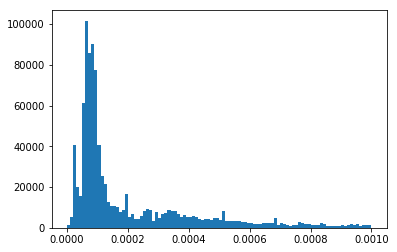

In [51]:
plt.hist(mse, bins=100, range=(0,0.001))
plt.show()
## Mse has the most ideal distribution. Therefore we use mse as fraud score 2.

In [1]:
mse.max()

NameError: name 'plt' is not defined

In [ ]:
measurement = (((matrix_pca - matrix_reproduce)**2).sum(axis=1))**0.5

In [ ]:
plt.hist(measurement, bins=100, range=(0,0.1))
plt.show()

In [ ]:
mae = (matrix_pca - matrix_reproduce).mean(axis=1)

In [ ]:
plt.hist(mae, bins=100, range=(0,0.1))
plt.show()